# VOLUME & BRIGHTNESS CONTROL

## MediaPipe offers cross-platform, customizable ML solutions for live and streaming media.
MediaPipe is a Framework for building machine learning pipelines for processing time-series data like video, audio, etc. This cross-platform Framework works in Desktop/Server, Android, iOS, and embedded devices like Raspberry Pi and Jetson Nano.

## Hand Landmark Model
- Hand landmark model performs precise keypoint localization of 21 3D hand-knuckle coordinates inside the detected hand regions via regression, that is direct coordinate prediction.

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


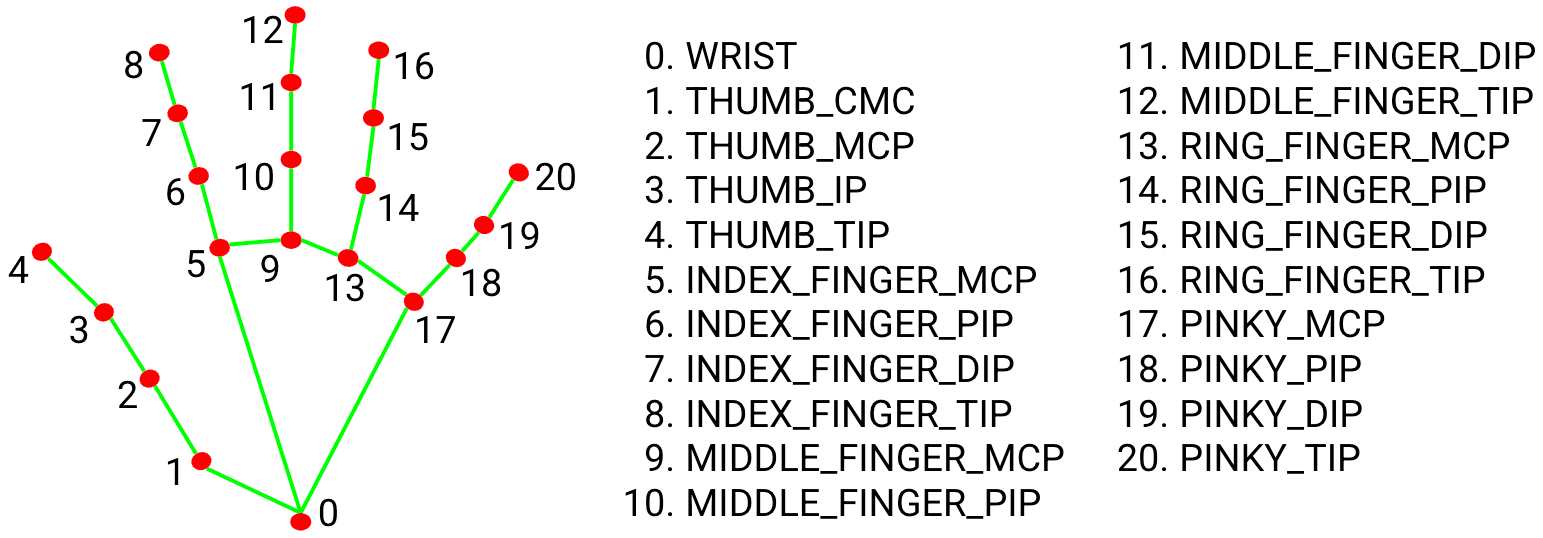

In [2]:
# Import libraries
import cv2   
import mediapipe as mp
import time 
import numpy as np
import math

### First step
- Deticte hands by Hand-Landmark model

In [3]:
class HandDetector():
    def __init__(self, mode=False, maxHands=2, detectionCon=0.5, trackCon=0.5):
        # parameters for the model
        self.mode = mode 
        self.maxHands = maxHands
        self.detectionCon = detectionCon
        self.trackCon = trackCon
        # call the model
        self.mpHands = mp.solutions.hands
        # initialize the parameters
        self.hands = self.mpHands.Hands(self.mode, self.maxHands, self.detectionCon, self.trackCon)
        # drawing the landmarks
        self.mpDraw = mp.solutions.drawing_utils
        
        
    # method for searching about hands    
    def findHands(self, img, draw=True):
        # convert image from BGR to RGB to works with mediapipe
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Detecting hands in the image
        self.results = self.hands.process(imgRGB)
        # print(results.multi_hand_landmarks)
        
        # Drawing landmarks for every hand
        if self.results.multi_hand_landmarks:
            for handLms in self.results.multi_hand_landmarks:
                if draw:
                    self.mpDraw.draw_landmarks(img, handLms, self.mpHands.HAND_CONNECTIONS)
        return img
    
    
    def findPosition(self, img, handNo=0, draw=True):
        # list for storing handmarks positions
        lmList = []
        # When a hand appears
        if self.results.multi_hand_landmarks:
            # take the first hand
            myHand = self.results.multi_hand_landmarks[handNo]
            # id= index of landmark
            # x,y of landmark
            for id, lm in enumerate(myHand.landmark):
                # print(id,lm)
                # shape of the image
                h, w, c = img.shape
                # knowing position of landmark
                # lm.x or lm.y return a ratio of the position x,y in the screen
                cx, cy = int(lm.x*w), int(lm.y*h)
                #print(id, cx, cy)
                lmList.append([id,cx,cy])
                if draw:
                    cv2.circle(img, (cx,cy),7,(255,0,255), cv2.FILLED)
        return lmList
    

In [37]:
# # running the class
 #def main():
  #  cap = cv2.VideoCapture(0)
   #  detector = HandDetector()
    #while True:
     #   success, img = cap.read()
#img  = detector.findHands(img)
#lmList = detector.findPosition(img)     
 # cv2.imshow("image",img)
  #       if cv2.waitKey(1) & 0xFF == ord('q'):
   #          break
    #cv2.destroyAllWindows()


### Second step
- Control volume and brightness using landmarks

In [5]:
# module for controlling in keyboard
from pynput.keyboard import Key,Controller
keyboard = Controller()

In [6]:
pip install pynput

Note: you may need to restart the kernel to use updated packages.


In [7]:
# knowing the volume range in the computer (https://github.com/AndreMiras/pycaw)
from ctypes import cast, POINTER
from comtypes import CLSCTX_ALL
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume
devices = AudioUtilities.GetSpeakers()
interface = devices.Activate(
    IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
volume = cast(interface, POINTER(IAudioEndpointVolume))
volume_range = volume.GetVolumeRange()

In [8]:
pip install pycaw

Note: you may need to restart the kernel to use updated packages.


In [9]:
# control in screen brightness
import screen_brightness_control as sbc
brightness = int(sbc.get_brightness()[0])

# width and height of the screen
wCam, hCam = 1280, 720

cap = cv2.VideoCapture(0)
# set width
cap.set(3,wCam)
# set height
cap.set(4,hCam)

# object from HandDetector class 
detector = HandDetector(detectionCon=0.7)


last_angle=None     
last_length=None

minAngle = int(volume_range[0])     # minimum volume range in pc
maxAngle = int(volume_range[1])     # maximum volume range`in pc
angle = 0                           
angleBar = 400                       
angleDeg = 0                        
minHand = 50                        # the minimum destance between landmarks 4,8
maxHand = 300                       # the maximum destance between landmarks 4,8

while True:
    success,img = cap.read() 
    # use findHabds mithod(return image after detecting the hands)
    img = detector.findHands(img)
    # use findPosition mithod(return landmarks list)
    lmList = detector.findPosition(img, draw=False)
    if len(lmList) !=0:
        #print(lmList[4],lmList[8])
        # using landmarks 4,8 and knowing x,y of them
        x1, y1 = lmList[4][1], lmList[4][2]
        x2, y2 = lmList[8][1], lmList[8][2]
        cx, cy = (x1+x2)//2,(y1+y2)//2
        # drawing circles on landmarks 4,8
        cv2.circle(img,(x1,y1),15,(0,0,255),cv2.FILLED)
        cv2.circle(img,(x2,y2),15,(0,0,255),cv2.FILLED)
        # drawing line between them
        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),3)
        # drawing circle between them
        cv2.circle(img,(cx,cy),15,(0,0,255),cv2.FILLED)
        
        #the hypotenuse of a right-angled triangle 
        #parendicular = x2-x1 , base = y2-y1
        length = math.hypot(x2-x1,y2-y1)
        #print(length)
        
        angle = np.interp(length, [minHand,maxHand], [minAngle, maxAngle])
        angleBar = np.interp(length,[minHand,maxHand], [400,150])
        angleDeg = np.interp(length,[minHand,maxHand], [0,100])
        
        # when the length be less than minimum destance
        if length< 50:
            cv2.circle(img, (cx, cy), 15, (0,255,0), cv2.FILLED)
        
        # if the landmark in the left side of screen you control in volume
        if lmList[8][1]< img.shape[1]/2:
        
            if last_length:
                if length >last_length:
                    keyboard.press(Key.media_volume_up)
                    keyboard.release(Key.media_volume_up)
                elif length<last_length:
                    keyboard.press(Key.media_volume_down)
                    keyboard.release(Key.media_volume_down)
            last_angle = angle
            last_length=length
            cv2.rectangle(img, (50,int(angleBar)), (85,400), (0,0,255),cv2.FILLED)
            cv2.putText(img, f'{int(angleDeg)}%', (40,120), cv2.FONT_HERSHEY_COMPLEX, 2, (0,0,255),3)    

        # if the landmark in the right side of screen you control in volume
        elif lmList[8][1]>= img.shape[1]/2:
            if last_length:
                if length >last_length:
                    brightness = brightness+5
                    sbc.set_brightness(brightness)

                elif length<last_length:
                    brightness = brightness-5
                    sbc.set_brightness(brightness)
            last_angle = angle
            last_length=length
            cv2.rectangle(img, (1195,int(angleBar)), (1230,400), (255,255,255),cv2.FILLED)
            cv2.putText(img, f'{int(angleDeg)}%', (1150,120), cv2.FONT_HERSHEY_COMPLEX, 2, (255,255,255),3) 
    
    # screen style 
    cv2.rectangle(img, (640,0), (641,640), (0,0,0),3)   
    cv2.rectangle(img, (50,150), (85,400), (0,0,255),3)
    cv2.rectangle(img, (1195,150), (1230,400), (255,255,255),3)    
    cv2.putText(img, "Volume", (50,650), cv2.FONT_HERSHEY_COMPLEX, 1,(0,0,255) ,2)    
    cv2.putText(img, "Brightness", (1050,650), cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,255),2)    

       
        
    cv2.imshow("image",img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [43]:
pip install screen-brightness-control


Note: you may need to restart the kernel to use updated packages.
